<a href="https://colab.research.google.com/github/maroprog/maroprog/blob/main/teste_lmicut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import *
from numpy.linalg import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB
# Set up environment
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.setParam('LogToConsole', 0)
env.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<gurobipy.Env, Parameter changes: LogToConsole=0, OutputFlag=0>

In [ ]:
def restric(n, G, v):
  G0 = G(zeros(n))
  b = -array([v@G0@v])  # gorubi requires 1-d ndarray
  a = zeros((1,n))      # gorubi requires 2-d ndarray
  e = eye(n)
  for i in range(n):
    a[0,i] = v@(G(e[:,i]) - G0)@v
  return a, b

In [ ]:
def lmicut(c, G, maxiter, tol, verbose):
# Dada G(x) uma função matricial linear, decide se a região viável de:
#   (1)     min c'*x
#           s.a. x em Omega1={x:G(x) semidefinida negativa e x>=0}
# é vazia.
#
# Em cada iteração constrói uma restrição a'x<=b que é adicionada ao problema
#   (2)     min c'*x
#           s.a: x em Omega2={x:Ax<=b e x>=0}
# se x for solução de problema (2) e max autoval(G(x))<tol, termina.
#
# Entradas:
#   c = gradiente da função objetivo
#   G = função matricial
#   maxiter = número máximo de iterações
#   tol = tolerância para a condição de parada
#   verbose = 1 mostra mensagens, 0 não mostra mensagens
# Saídas:
#   x == [] caso gorubi não consiga calcular a solução de (2) ou
#   x != [] caso gorubi encontre solução x para (2) e max(autoval(G(x)))<tol
#   fobj = array com o valor de c@x com x de cada interação
  nvar = len(c)
  mmat = len(G(c))
  m = gp.Model()
  xm = m.addMVar(nvar) # non-negative by default (https://www.gurobi.com/documentation/9.5/refman/variables.html)
  m.setMObjective(None, c, 0.0, None, None, xm, GRB.MINIMIZE)
  x = zeros(nvar)
  fobj = zeros(maxiter+1)
  k = 0 
  while k < maxiter:
    Gx = G(x)
    autoval, autovec = eig(Gx)
    autovalpos = sum(autoval>tol) # número de autovalores maiores que tol
    maxautoval = max(autoval)
    fobj[k] = c@x
    if verbose:
      if k % 20 == 0:
        print(str('k').rjust(5), str('fobj').rjust(10), str('lambdamax').rjust(10),str('lambda>epsilon').center(15))
      print(str(k).rjust(5), str("%1.2e"%(fobj[k])).rjust(10), str("%1.2e"%(maxautoval)).rjust(10),str(autovalpos).center(15))
    if maxautoval <= tol:
      break
    else: # existe algum autovalor maior que tol
      index = argsort(autoval)
      autoval = autoval[index] # sort autoval de menor para maior
      autovec = autovec[:,index]
      v = autovec[:,-1] # autovetor com maior autovalor, maior que tol
      a, b = restric(nvar, G, v) # talvez melhorar eficiência
      m.addMConstr(a, xm, '<=', b)
      m.optimize()
      if m.Status == GRB.OPTIMAL:
        x = m.getAttr(GRB.Attr.X, m.getVars()) # lista com as entradas de x
        x = array(x)
        k = k + 1
        continue
      elif m.Status == GRB.INFEASIBLE:
        if verbose:
          print('lmicut: model.Status = GRB.INFEASIBLE\n') # Omega1 == vazio ?
      else:
        if verbose:
          print('lmicut: model.Status not GRB.INFEASIBLE and not GRB.OPTIMAL\n')
      x = array([])
      break

  if k == maxiter and verbose:
      print('sdpcut: k > maxiter\n')
  if maxautoval >= tol and verbose:
      print('sdpcut: maxautoval>=tol\n')

  fobj = fobj[:k]
	
  return x, fobj

In [ ]:
def data_cantilever3D_12n():

  coord = array([
      [0,   0,   0],
      [0,   1,   0],
      [0,   1,   1],
      [0,   0,   1],
      [1,   0,   0],
      [1,   1,   0],
      [1,   1,   1],
      [1,   0,   1],
      [2,   0,   0],
      [2,   1,   0],
      [2,   1,   1],
      [2,   0,   1]
  ])
  nn = coord.shape[0] # number of nodes
  nsd = coord.shape[1] # number of space dimension

  # truss elements
  n1,n2 = meshgrid(range(nn),range(nn))
  truss = vstack((n1.flatten(),n2.flatten())).T
  # Remove elements of zero length
  truss = truss[truss[:,0]!=truss[:,1],:]   # (****)
  # Make sure there is only one (and not two) element between each pair of nodes
  truss = unique(sort(truss,axis=1),axis=0)
  # Remove elements longer than distmax
  n1 = truss[:,0]
  c1 = coord[n1,:]
  n2 = truss[:,1];
  c2 = coord[n2,:];
  dc = c2-c1; # any(abs(dc(i,:))>0) is true becouse of (****)
  lengths = sqrt(dc[:,0]**2 + dc[:,1]**2 + dc[:,2]**2)
  distmax = sqrt(2) # lengths.max()
  truss = truss[lengths <= distmax,:]
  lengths = lengths[lengths <= distmax]

  # Remove elements colinear and longer than smaller ones
  #nel = truss.shape[0]
  #elem2rem = zeros(nel)
  #for i in range(nel):
  #    for j in range(nn):
  #        if j != n1[i] and j != n2[i]:
  #            A = array([[dc[i,1], -dc[i,0], 0       ],
  #                       [0,       -dc[i,2], dc[i,1] ],
  #                       [dc[i,2], 0,        -dc[i,0]]])
  #            v = coord[j,:] - c1[i,:]
  #            if norm(A@v) < 1e-6: # true if n1 n2 j colinear
  #                k = (abs(dc[i,:]) > 1e-6).argmax()
  #                param = (coord[j,k]-c1[i,k])/dc[i,k]
  #                if 0 < param and param < 1: # true if truss[i,:] contains j
  #                    elem2rem[i] = 1
  #                    break
  #print(elem2rem)
  #truss = truss[elem2rem != 1,:]
  nel = truss.shape[0] # number of elements

  dof = zeros((nel,nsd*2),dtype=int) # degree of freedom
  for i in range(nel):
      no1 = truss[i,0]
      no2 = truss[i,1]
      o1 = no1*nsd
      o2 = no2*nsd
      dof[i,:] = array([o1+0, o1+1, o1+2, o2+0, o2+1, o2+2])
  
  ndof = dof.max() + 1 # number of degree of freedom
  if nn*3 != ndof:
    print('Error: Wrong number of degree of freedom.')
    return # att

  doff = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])-1
  if all(coord[:,nsd-1]==0):
      doff = hstack((doff, dof[:,2], dof[:,5]))
  doff = unique(doff) # dof fixed

  bdofa = ones(ndof) # boolean dof active
  bdofa[doff] = 0    # put 0        in doff
  bdofa = bdofa==1   # put True not in doff
  dofa = arange(ndof)
  dofa = dofa[bdofa] # dof active (dof without fixed dof)

  E = 1000.0 # Pa, Young's module
  rho = 1.0 # kg/m^3, density
  
  x = ones(nel) # truss sectional area

  f = zeros(ndof)
  # self weight
  g = 9.81 # m/s^2
 # for i in range(nel): # truss self weight, 'for' way
 #   tsw = rho*x[i]*lengths[i]*g
 #   f[dof[i,2]] = -0.5*tsw
 #   f[dof[i,5]] = -0.5*tsw
  tsw = rho*x*lengths*g # truss self weight, 'for free' way
  f[dof[:,2]] = -0.5*tsw # vetical downward half weight
  f[dof[:,5]] = -0.5*tsw # vetical downward half weight
 # concentrated node forces
 # f[9*3+3] = 100.0 # N
 # f[10*3+3] = 100.0 # N
  f = f[dofa]
  
  gama = 1
  lamb = 5e-2

  return coord, truss, dof, dofa, E, rho, f, gama, lamb, x

In [ ]:
def draw(coord,truss,u,dof,x,opt):

  coordesloc = zeros(coord.shape)
  nel = truss.shape[0]
  for i in range(nel):
      no1 = truss[i,0]
      no2 = truss[i,1]
      coordesloc[no1,:] = coord[no1,:] + u[dof[i,0:3]]
      coordesloc[no2,:] = coord[no2,:] + u[dof[i,3:6]]

  maxcoord = coord.max();
  width = x/x.max()*maxcoord*2;
  minwidth = 1e-3;

  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  for i in range(nel):
      no1 = truss[i,0]
      no2 = truss[i,1]
      if opt[0] == 1:
        ax.plot([coord[no1,0], coord[no2,0]],[coord[no1,1], coord[no2,1]],[coord[no1,2], coord[no2,2]],'--r')
      if opt[1] == 1:
        ax.plot([coordesloc[no1,0], coordesloc[no2,0]],[coordesloc[no1,1], coordesloc[no2,1]],[coordesloc[no1,2], coordesloc[no2,2]],'-b')
      if opt[2] == 1 and width[i] > minwidth:
        ax.plot([coord[no1,0], coord[no2,0]],[coord[no1,1], coord[no2,1]],[coord[no1,2], coord[no2,2]],'k',linewidth=width[i])

  ax.view_init(20, -180+45+5)
  #ax.set_aspect('equal')
  #plt.axes().set_aspect('equal')

In [ ]:
def mat_K_M(x,truss,coord,E,rho,dof,dofa):
  ndof = dof.max() + 1 # Attention: + 1 because dof has 0 as a degree of freedom
  K = zeros((ndof,ndof))
  M = zeros((ndof,ndof))
  nel = truss.shape[0]
  for i in range(nel):
    no1 = truss[i,0]
    no2 = truss[i,1]
    p1 = coord[no1,:]
    p2 = coord[no2,:]
    r = p2 - p1
    L = norm(r)
    p = r/L
    alfa = E*x[i]/L # x(i) = area da seção transversal
    #alfa = E*x(i)/(L*L); # x(i) = área da seção transversal por L (volume), usado para comparar com fminsdp.m
    gama = (1/6)*rho*x[i]*L; # x(i) = area da seção transversal
    #gama = (1/6)*rho*x(i); % x(i) = área da seção transversal por L (vol), usado para comparar com fminsdp.m
    Q = vstack((vstack((p,zeros(3))).T,vstack((zeros(3),p)).T)) #[p zeros(3,1);zeros(3,1) p]
    Ke = alfa*Q@array([[1,-1],[-1,1]])@Q.T
    Me = gama*Q@array([[2, 1],[1, 2]])@Q.T
    dof12 = dof[i,:]
    # https://stackoverflow.com/questions/26506204/replace-sub-part-of-matrix-by-another-small-matrix-in-numpy
    # K(dof12,dof12) = K(dof12,dof12) + Ke;
    AUX = K[dof12,:]
    AUX[:,dof12] = AUX[:,dof12] + Ke
    K[dof12,:] = AUX
    # M(dof12,dof12) = M(dof12,dof12) + Me;
    AUX = M[dof12,:]
    AUX[:,dof12] = AUX[:,dof12] + Me
    M[dof12,:] = AUX

  bdofa = zeros(ndof)
  bdofa[dofa] = 1
  bdofa = bdofa==1
  #K = K(dofa,dofa);
  K = K[bdofa,:]
  K = K[:,bdofa]
  #M = M(dofa,dofa);
  M = M[bdofa,:]
  M = M[:,bdofa]
  return K,M

In [ ]:
def G_compl(x,gama,f,truss,coord,E,rho,dof,dofa):
  K = mat_K_M(x,truss,coord,E,rho,dof,dofa)
  K = K[0]
  f = reshape(f,(len(f),1))
  G = block([[-gama, f.T],[ f, -K]])
  return G

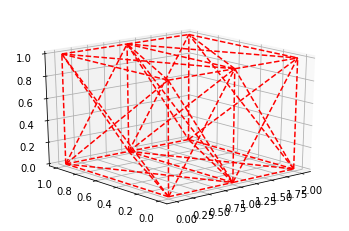

In [ ]:
coord, truss, dof, dofa, E, rho, f, gama, lamb, x = data_cantilever3D_12n()
ndof = dof.max() + 1
nel = len(truss)

draw(coord,truss,zeros(ndof),dof,x,array([1,0,0]))

In [ ]:
c = ones(nel)
G = lambda x: G_compl(x,gama,f,truss,coord,E,rho,dof,dofa)
maxiter = 10*nel*ndof # número máximo de iterações
tol = 1e-6
verbose = 1
xP1, fP1 = lmicut(c, G, maxiter, tol, verbose)

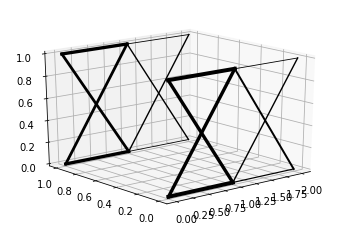

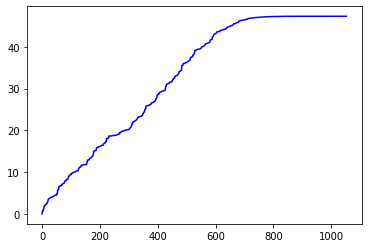

In [ ]:
draw(coord,truss,zeros(ndof),dof,xP1,array([0,0,1]))
plt.figure()
plt.plot(range(len(fP1)),fP1,'b')